In [1]:
from src.DeepRock.models import AdvSeg
from src.DeepRock.data import DataGenerator
from src.DeepRock.utils import split_trn_vld_tst, test_fn, plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn import metrics

Using TensorFlow backend.


In [2]:
def get_iou(precision, recall, support):
    intersection = support * recall
    preds_sup = intersection / precision
    preds_sup[precision == 0.0] = 0.0
    return intersection / (support + preds_sup - intersection)

In [3]:
cls_names = ['Vegetation', 'Unkown \nRocks', 'Carbonate \nsediment',
             'Dolerite', 'Feldspathic \nsediment', 'Felsic \nvolcanic',
             'Gneiss', 'Granite', 'Mafic \nvolcanic', 'Quartz \nsediment']
cls_merged = ['Vegetation', 'Unkown \nRocks', 'Sediments',
              'Dolerite', 'Felsic \nvolcanic', 'Gneiss', 'Granite', 'Mafic \nvolcanic']

#### start to build Conv2D for different input data

In [ ]:
dtype = 'sent_ast_geo'

In [3]:
conv = AdvSeg(dtype=dtype)
# sa_conv = AdvSeg(dtype=sa_dtype)
# sag_conv = AdvSeg(dtype=sag_dtype)
conv.build_SegmentationNet()
# sa_conv.build_SegmentationNet()
# sag_conv.build_SegmentationNet()

building Segmentation U-net ...
[64, 64, 64, 64]
[64, 64, 64]
compiling Segmentation only, lr is 0.001 ...


##### plot the ground truth

In [24]:
# convert the ground truth into a big block
block_id = 1
ids = sorted(glob.glob('./data/block{0}/test/Y/*.npy'.format(block_id)), key=lambda f: int(''.join(filter(str.isdigit, f))))
count = 0
track = []
for i in range(5):
    tmp1 = []
    for j in range(5):
        tmp1.append(np.argmax(np.load(ids[count]), axis=0))
        count += 1
    track.append(np.concatenate(tmp1, axis=1))
out = np.concatenate(track, axis=0)
np.save('./data/block{0}/Y.npy'.format(block_id), out)

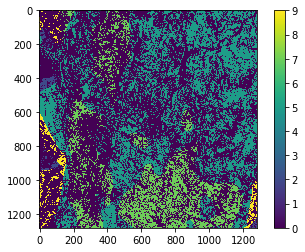

In [49]:
plt.imshow(out)
plt.colorbar()

##### load weights and predicts

In [16]:
conv.load_weights('./Segmentation/sent_ast_geo/weights-151-0.66.hdf5')

## test on 3 blocks

In [18]:
count = 0
track = []
for i in range(5):
    tmp1 = []
    for j in range(5):
        tmp1.append(np.argmax(preds[count,:,:,:], axis=2))
        count += 1
    track.append(np.concatenate(tmp1, axis=1))
p = np.concatenate(track, axis=0)
np.save('./data/block{0}/preds_{1}.npy'.format(block_id, dtype), p)

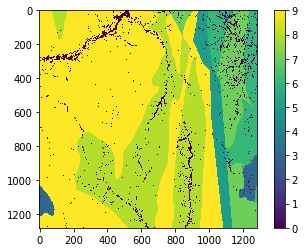

In [11]:
Y = np.load('./data/block1/Y.npy')
plt.imshow(Y)
plt.colorbar()

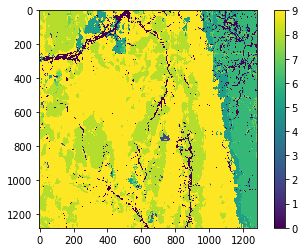

In [15]:
p2 = np.load('./data/block1/preds_sent_ast.npy')
plt.imshow(p2)
plt.colorbar()

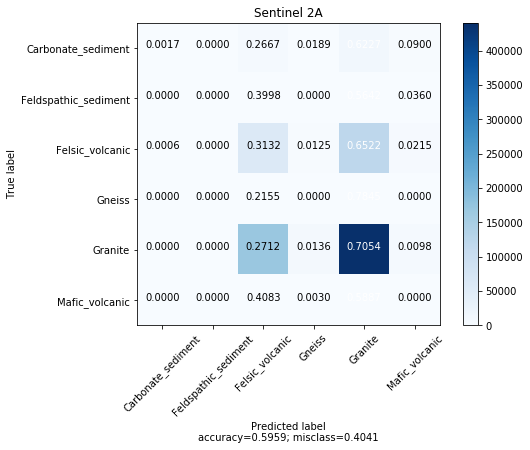

In [98]:
p1 = np.load('./data/block2/preds_sent.npy')
cm = metrics.confusion_matrix(Y.flatten(), p1.flatten(), labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A')

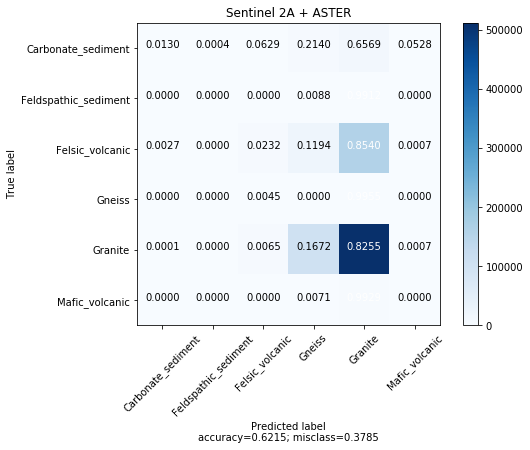

In [99]:
p2 = np.load('./data/block2/preds_sent_ast.npy')
cm = metrics.confusion_matrix(Y.flatten(), p2.flatten(), labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A + ASTER')

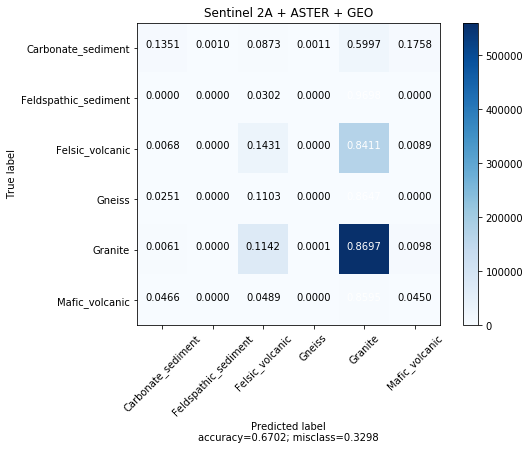

In [100]:
p3 = np.load('./data/block2/preds_sent_ast_geo.npy')
cm = metrics.confusion_matrix(Y.flatten(), p3.flatten(), labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A + ASTER + GEO')

#### test on all 3 blocks

In [15]:
Y = np.concatenate([np.load('./data/block1/Y.npy').flatten(), 
                    np.load('./data/block2/Y.npy').flatten(), 
                    np.load('./data/block3/Y.npy').flatten()])

In [16]:
p1 = np.concatenate([np.load('./data/block1/preds_sent.npy').flatten(),
                     np.load('./data/block2/preds_sent.npy').flatten(),
                     np.load('./data/block3/preds_sent.npy').flatten()])
p2 = np.concatenate([np.load('./data/block1/preds_sent_ast.npy').flatten(),
                     np.load('./data/block2/preds_sent_ast.npy').flatten(),
                     np.load('./data/block3/preds_sent_ast.npy').flatten()])
p3 = np.concatenate([np.load('./data/block1/preds_sent_ast_geo.npy').flatten(),
                     np.load('./data/block2/preds_sent_ast_geo.npy').flatten(),
                     np.load('./data/block3/preds_sent_ast_geo.npy').flatten()])

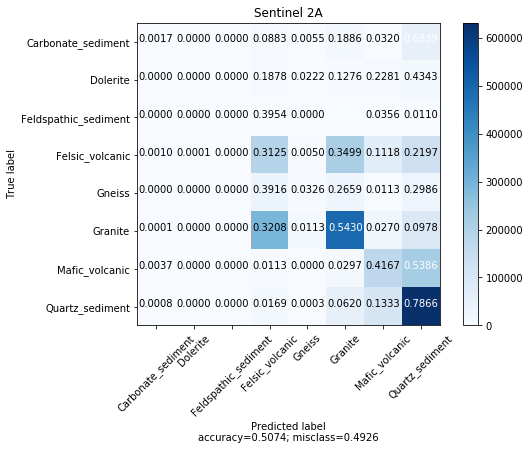

In [24]:
cm = metrics.confusion_matrix(Y, p1, labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A')

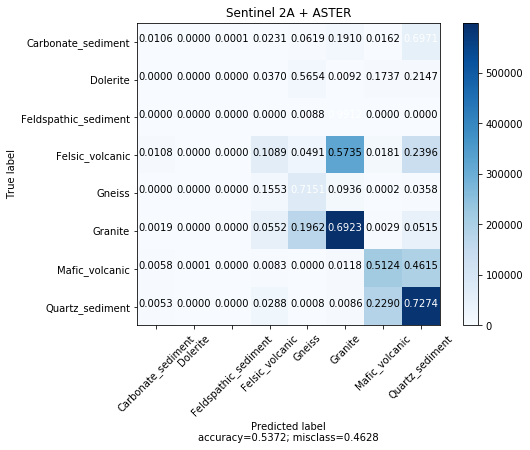

In [21]:
cm = metrics.confusion_matrix(Y, p2, labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A + ASTER')

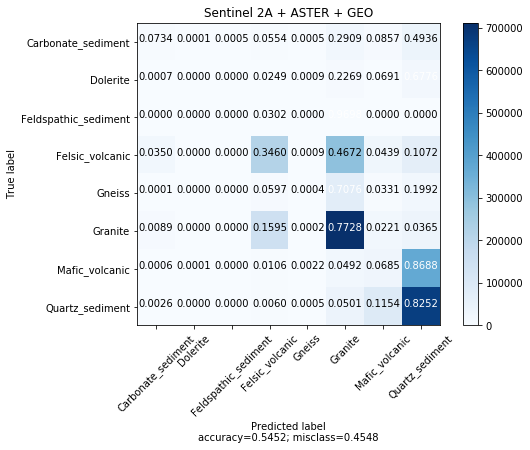

In [22]:
cm = metrics.confusion_matrix(Y, p3, labels=np.unique(Y)[1:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[1:]], 
                      normalize=True, title='Sentinel 2A + ASTER + GEO')

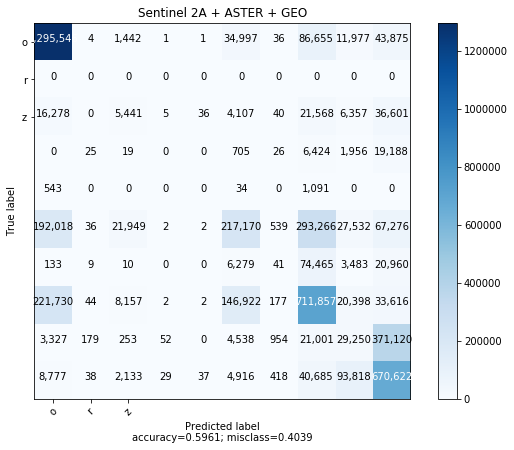

In [176]:
cm = metrics.confusion_matrix(Y, p3, labels=np.arange(10))
plot_confusion_matrix(cm, target_names='orz', 
                      normalize=False, title='Sentinel 2A + ASTER + GEO')

In [8]:
pr1, re1, fs1, s1 = metrics.precision_recall_fscore_support(Y, p1)
pr2, re2, fs2, s2 = metrics.precision_recall_fscore_support(Y, p2)
pr3, re3, fs3, s3 = metrics.precision_recall_fscore_support(Y, p3)

/Users/chenyz/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chenyz/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


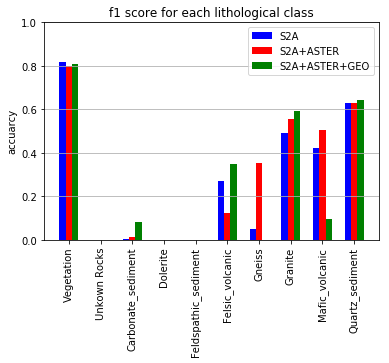

In [14]:
ax = plt.subplot(111)
plt.ylim(0., 1.)
ax.bar(np.arange(10)-0.2, fs1[:], width=0.2, color='b', align='center', label='S2A')
ax.bar(np.arange(10), fs2[:], width=0.2, color='r', align='center', label='S2A+ASTER')
ax.bar(np.arange(10)+0.2, fs[:], width=0.2, color='g', align='center', label='S2A+ASTER+GEO')
plt.xticks(np.arange(10), cls_names[:], rotation=90)
plt.ylabel('accuarcy')
plt.gca().yaxis.grid(True)
plt.title('f1 score for each lithological class')
plt.legend()

## test on block1 with 64X64 tile size

In [80]:
X_sag = np.load('./data/block1_64/X_tst.npy')
X_sa = X_sag[:,:,:,:16]
X_s = X_sag[:,:,:,:10]
Y_s = np.load('./data/block1_64/Y_tst.npy')

In [109]:
s_conv = AdvSeg(dtype='sent', dim_width=64, dim_height=64)
sa_conv = AdvSeg(dtype='sent_ast', dim_width=64, dim_height=64)
sag_conv = AdvSeg(dtype='sent_ast_geo', dim_width=64, dim_height=64)
s_conv.build_SegmentationNet(n_ch_list=[64, 64])
sa_conv.build_SegmentationNet(n_ch_list=[64, 64])
sag_conv.build_SegmentationNet(n_ch_list=[64, 64])

building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...
building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...
building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...


In [110]:
s_conv.load_weights('./Segmentation/Segmentation-all/sent/weights-86-0.68.hdf5')
sa_conv.load_weights('./Segmentation/Segmentation-all/sent_ast/weights-91-0.70.hdf5')
sag_conv.load_weights('./Segmentation/Segmentation-all/sent_ast_geo/weights-87-0.49.hdf5')

In [83]:
p_s = s_conv.predict(X_s)
p_sa = sa_conv.predict(X_sa)
p_sag = sag_conv.predict(X_sag)

In [84]:
Y = np.argmax(Y_s, axis=3).flatten()
max1 = np.argmax(p_s, axis=3).flatten()
max2 = np.argmax(p_sa, axis=3).flatten()
max3 = np.argmax(p_sag, axis=3).flatten()
score1 = np.max(p_s, axis=3).flatten()
score2 = np.max(p_sa, axis=3).flatten()
score3 = np.max(p_sag, axis=3).flatten()

In [85]:
th = 0.5
p1 = np.copy(max1)
p1[score1 < th] = 1
p2 = np.copy(max2)
p2[score2 < th] = 1
p3 = np.copy(max3)
p3[score3 < th] = 1

In [86]:
pr1, re1, fs1, s1 = metrics.precision_recall_fscore_support(Y, p1, labels=np.unique(Y))
pr2, re2, fs2, s2 = metrics.precision_recall_fscore_support(Y, p2, labels=np.unique(Y))
pr3, re3, fs3, s3 = metrics.precision_recall_fscore_support(Y, p3, labels=np.unique(Y))
iou1 = get_iou(pr1, re1, s1)
iou2 = get_iou(pr2, re2, s2)
iou3 = get_iou(pr3, re3, s3)

/Users/chenyz/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chenyz/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


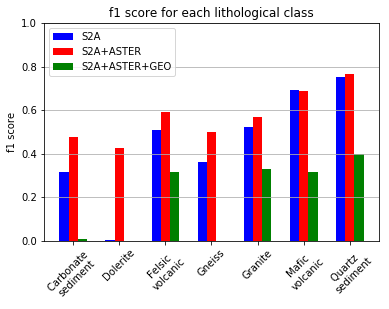

In [87]:
ax = plt.subplot(111)
plt.ylim(0., 1.)
ax.bar(np.arange(7)-0.2, fs1[2:], width=0.2, color='b', align='center', label='S2A')
ax.bar(np.arange(7), fs2[2:], width=0.2, color='r', align='center', label='S2A+ASTER')
ax.bar(np.arange(7)+0.2, fs3[2:], width=0.2, color='g', align='center', label='S2A+ASTER+GEO')
plt.xticks(np.arange(7), [cls_names[i] for i in np.unique(Y)[2:]], rotation=45)
plt.ylabel('f1 score')
plt.gca().yaxis.grid(True)
plt.title('f1 score for each lithological class')
plt.legend()

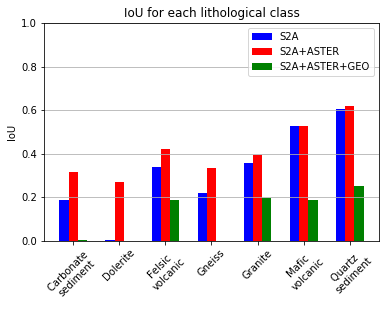

In [88]:
ax = plt.subplot(111)
plt.ylim(0., 1.)
ax.bar(np.arange(7)-0.2, iou1[2:], width=0.2, color='b', align='center', label='S2A')
ax.bar(np.arange(7), iou2[2:], width=0.2, color='r', align='center', label='S2A+ASTER')
ax.bar(np.arange(7)+0.2, iou3[2:], width=0.2, color='g', align='center', label='S2A+ASTER+GEO')
plt.xticks(np.arange(7), [cls_names[i] for i in np.unique(Y)[2:]], rotation=45)
plt.ylabel('IoU')
plt.gca().yaxis.grid(True)
plt.title('IoU for each lithological class')
plt.legend()

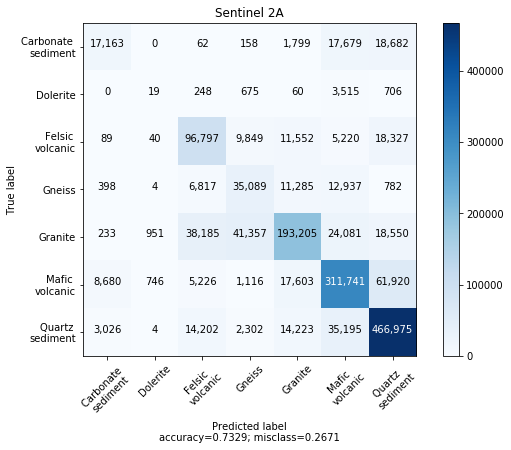

In [89]:
cm = metrics.confusion_matrix(Y, p1, labels=np.unique(Y)[2:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[2:]], 
                      normalize=False, title='Sentinel 2A')

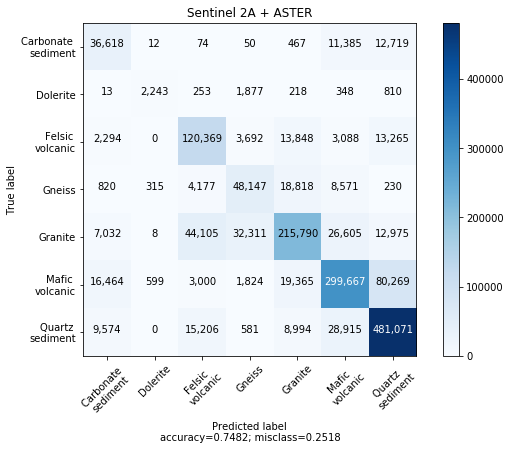

In [90]:
cm = metrics.confusion_matrix(Y, p2, labels=np.unique(Y)[2:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[2:]], 
                      normalize=False, title='Sentinel 2A + ASTER')

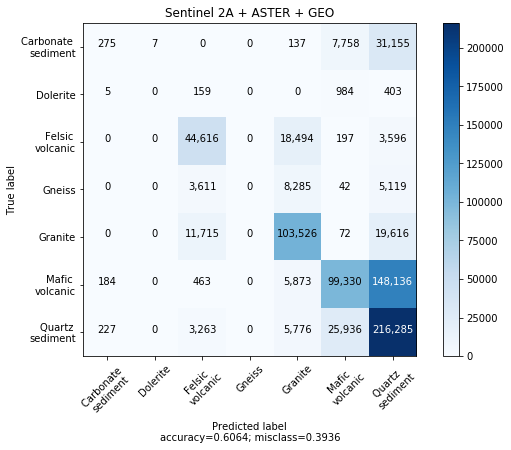

In [91]:
cm = metrics.confusion_matrix(Y, p3, labels=np.unique(Y)[2:])
plot_confusion_matrix(cm, target_names=[cls_names[i] for i in np.unique(Y)[2:]], 
                      normalize=False, title='Sentinel 2A + ASTER + GEO')

#### test on merged block1 64X64

In [92]:
X_sag = np.load('./data/block1_64/X_tst.npy')
X_sa = X_sag[:,:,:,:16]
X_s = X_sag[:,:,:,:10]
mY_s = np.load('./data/block1_64/mY_tst.npy')

In [93]:
s_conv = AdvSeg(dtype='sent', dim_width=64, dim_height=64, num_labels=8)
sa_conv = AdvSeg(dtype='sent_ast', dim_width=64, dim_height=64, num_labels=8)
sag_conv = AdvSeg(dtype='sent_ast_geo', dim_width=64, dim_height=64, num_labels=8)
s_conv.build_SegmentationNet(n_ch_list=[64, 64])
sa_conv.build_SegmentationNet(n_ch_list=[64, 64])
sag_conv.build_SegmentationNet(n_ch_list=[64, 64])

building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...
building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...
building Segmentation U-net ...
[64, 64]
[64]
compiling Segmentation only, lr is 0.001 ...


In [94]:
s_conv.load_weights('./Segmentation/Segmentation-merged/sent/weights-93-0.69.hdf5')
sa_conv.load_weights('./Segmentation/Segmentation-merged/sent_ast/weights-93-0.72.hdf5')
sag_conv.load_weights('./Segmentation/Segmentation-merged/sent_ast_geo/weights-92-0.51.hdf5')

In [95]:
mp_s = s_conv.predict(X_s)
mp_sa = sa_conv.predict(X_sa)
mp_sag = sag_conv.predict(X_sag)

In [96]:
mY = np.argmax(mY_s, axis=3).flatten()
max1 = np.argmax(mp_s, axis=3).flatten()
max2 = np.argmax(mp_sa, axis=3).flatten()
max3 = np.argmax(mp_sag, axis=3).flatten()
score1 = np.max(mp_s, axis=3).flatten()
score2 = np.max(mp_sa, axis=3).flatten()
score3 = np.max(mp_sag, axis=3).flatten()

In [97]:
th = 0.5
p1 = np.copy(max1)
p1[score1 < th] = 1
p2 = np.copy(max2)
p2[score2 < th] = 1
p3 = np.copy(max3)
p3[score3 < th] = 1

In [98]:
pr1, re1, fs1, s1 = metrics.precision_recall_fscore_support(mY, p1, labels=np.unique(mY))
pr2, re2, fs2, s2 = metrics.precision_recall_fscore_support(mY, p2, labels=np.unique(mY))
pr3, re3, fs3, s3 = metrics.precision_recall_fscore_support(mY, p3, labels=np.unique(mY))
iou1 = get_iou(pr1, re1, s1)
iou2 = get_iou(pr2, re2, s2)
iou3 = get_iou(pr3, re3, s3)

/Users/chenyz/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chenyz/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


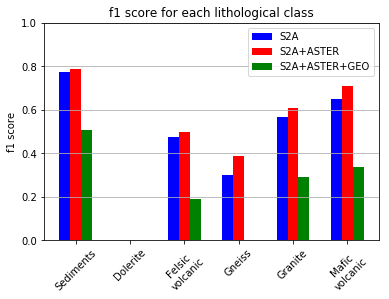

In [99]:
ax = plt.subplot(111)
plt.ylim(0., 1.)
ax.bar(np.arange(6)-0.2, fs1[2:], width=0.2, color='b', align='center', label='S2A')
ax.bar(np.arange(6), fs2[2:], width=0.2, color='r', align='center', label='S2A+ASTER')
ax.bar(np.arange(6)+0.2, fs3[2:], width=0.2, color='g', align='center', label='S2A+ASTER+GEO')
plt.xticks(np.arange(6), [cls_merged[i] for i in np.unique(mY)[2:]], rotation=45)
plt.ylabel('f1 score')
plt.gca().yaxis.grid(True)
plt.title('f1 score for each lithological class')
plt.legend()

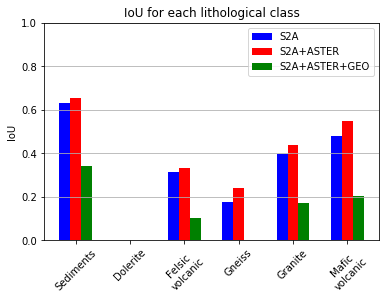

In [100]:
ax = plt.subplot(111)
plt.ylim(0., 1.)
ax.bar(np.arange(6)-0.2, iou1[2:], width=0.2, color='b', align='center', label='S2A')
ax.bar(np.arange(6), iou2[2:], width=0.2, color='r', align='center', label='S2A+ASTER')
ax.bar(np.arange(6)+0.2, iou3[2:], width=0.2, color='g', align='center', label='S2A+ASTER+GEO')
plt.xticks(np.arange(6), [cls_merged[i] for i in np.unique(mY)[2:]], rotation=45)
plt.ylabel('IoU')
plt.gca().yaxis.grid(True)
plt.title('IoU for each lithological class')
plt.legend()

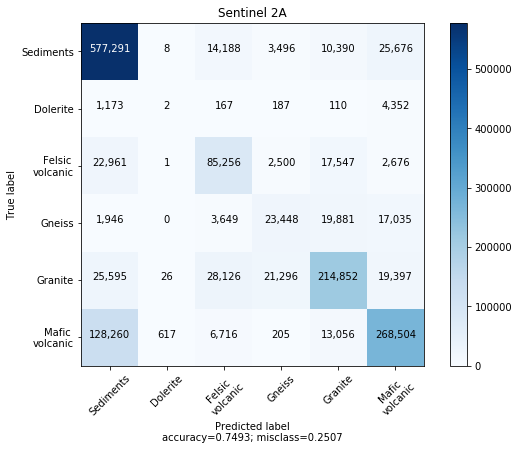

In [101]:
cm = metrics.confusion_matrix(mY, p1, labels=np.unique(mY)[2:])
plot_confusion_matrix(cm, target_names=[cls_merged[i] for i in np.unique(mY)[2:]], 
                      normalize=False, title='Sentinel 2A')

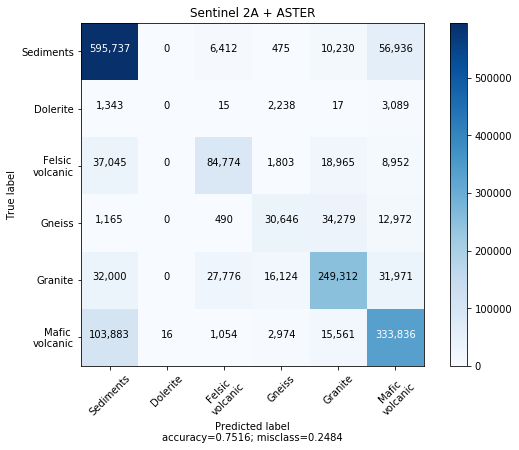

In [102]:
cm = metrics.confusion_matrix(mY, p2, labels=np.unique(mY)[2:])
plot_confusion_matrix(cm, target_names=[cls_merged[i] for i in np.unique(mY)[2:]], 
                      normalize=False, title='Sentinel 2A + ASTER')

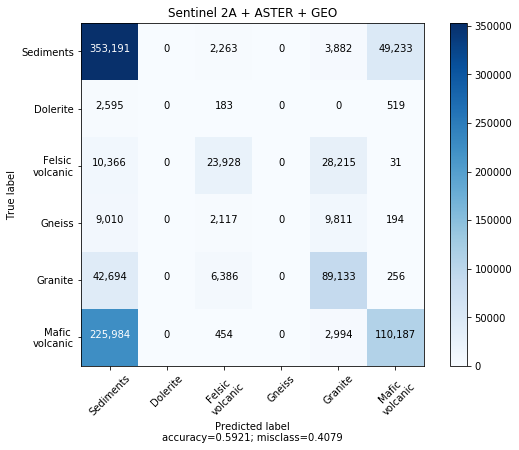

In [103]:
cm = metrics.confusion_matrix(mY, p3, labels=np.unique(mY)[2:])
plot_confusion_matrix(cm, target_names=[cls_merged[i] for i in np.unique(mY)[2:]], 
                      normalize=False, title='Sentinel 2A + ASTER + GEO')

In [112]:
block_id = 1
X_id = sorted(glob.glob('./data/block{0}/test/X/*.npy'.format(block_id)), key=lambda f: int(''.join(filter(str.isdigit, f))))
X = [np.transpose(np.load(file)[:16,:,:], [1,2,0]) for file in X_id]

In [134]:
def split(x):
    xx = []
    for i in range(4):
        for j in range(4):
            xx.append(np.copy(x[i*64:(i+1)*64, j*64:(j+1)*64, :]))
    return np.stack(xx)

def combine(x):
    out = np.zeros([256, 256, x.shape[-1]])
    count = 0
    for i in range(4):
        for j in range(4):
            out[i*64:(i+1)*64, j*64:(j+1)*64, :] = x[count, :, :, :]
            count += 1
    return out

In [135]:
plist = []
for xx in X:
    x_ = split(xx)
    p_ = sa_conv.predict(x_)
    plist.append(combine(p_))
preds = np.stack(plist)

In [142]:
count = 0
track = []
for i in range(5):
    tmp1 = []
    for j in range(5):
        maxx = np.argmax(preds[count,:,:,:], axis=2)
        score = np.max(preds[count,:,:,:], axis=2)
        maxx[score < th] = 1 
        tmp1.append(maxx)
        count += 1
    track.append(np.concatenate(tmp1, axis=1))
p = np.concatenate(track, axis=0)
np.save('./data/block1_64/preds_sa.npy', p)

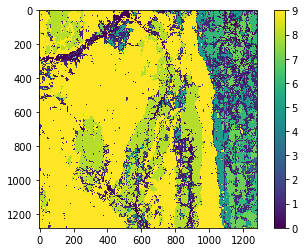

In [143]:
plt.imshow(p)
plt.colorbar()

In [139]:
# block_id = 1
# ids = sorted(glob.glob('./data/block{0}/test/Y/*.npy'.format(block_id)), key=lambda f: int(''.join(filter(str.isdigit, f))))
# count = 0
# track = []
# for i in range(5):
#     tmp1 = []
#     for j in range(5):
#         tmp1.append(np.argmax(np.load(ids[count]), axis=0))
#         count += 1
#     track.append(np.concatenate(tmp1, axis=1))
# out = np.concatenate(track, axis=0)
# np.save('./data/block{0}/Y.npy'.format(block_id), out)

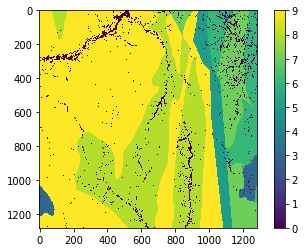

In [140]:
Y = np.load('./data/block1/Y.npy')
plt.imshow(Y)
plt.colorbar()